In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.linear_model import LogisticRegression
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the cleaned dataset
data = pd.read_csv('cleaned_student_data2.csv')

# Define the target and features
target = 'G3'
features = data.drop(columns=[target])
sensitive_feature = 'age'

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['G3_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive feature
data['age_bin'] = pd.cut(data['age'], bins=5, labels=False)


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, data['G3_binary'], test_size=0.2, random_state=42)

# Reset indices to ensure alignment
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Base Model Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained base model
y_pred_binary = rf_model.predict(X_test)

# Define a function to calculate different metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

# Compute metrics for different groups for the base model
metrics_base = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print the overall metrics for the base model
print("Overall Metrics for Base Model:")
print(metrics_base.overall)

# Print metrics by sensitive feature groups for the base model
print("\nMetrics by Sensitive Feature Groups for Base Model:")
print(metrics_base.by_group)


Overall Metrics for Base Model:
{'accuracy': 0.8481012658227848, 'precision': 0.8125, 'recall': 0.9285714285714286, 'f1': 0.8666666666666667}

Metrics by Sensitive Feature Groups for Base Model:
age_bin
0    {'accuracy': 0.8461538461538461, 'precision': ...
1    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


In [3]:
# Custom Reweighing Function
def compute_sample_weights(X, y, sensitive_feature):
    df = X.copy()
    df['y'] = y
    df['sensitive'] = sensitive_feature
    # Calculate group counts
    group_counts = df.groupby('sensitive')['y'].count()
    group_positive_counts = df.groupby('sensitive')['y'].sum()
    group_negative_counts = group_counts - group_positive_counts
    # Calculate weights
    positive_weight = 1.0 / group_positive_counts
    negative_weight = 1.0 / group_negative_counts
    df['weight'] = df.apply(lambda row: positive_weight[row['sensitive']] if row['y'] == 1 else negative_weight[row['sensitive']], axis=1)
    return df['weight'].values

# Apply reweighing
sample_weights = compute_sample_weights(X_train, y_train, data.loc[X_train.index, 'age_bin'])

# Train a Random Forest model with reweighed samples
rf_model_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predict using the trained reweighed model
y_pred_binary_rw = rf_model_rw.predict(X_test)

# Compute metrics for the reweighed model
metrics_rw = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_binary_rw,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print the overall metrics for the reweighed model
print("Overall Metrics for Reweighed Model:")
print(metrics_rw.overall)

# Print metrics by sensitive feature groups for the reweighed model
print("\nMetrics by Sensitive Feature Groups for Reweighed Model:")
print(metrics_rw.by_group)


Overall Metrics for Reweighed Model:
{'accuracy': 0.8734177215189873, 'precision': 0.82, 'recall': 0.9761904761904762, 'f1': 0.8913043478260869}

Metrics by Sensitive Feature Groups for Reweighed Model:
age_bin
0    {'accuracy': 0.8717948717948718, 'precision': ...
1    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


In [4]:
# Define custom fairness metric functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_positive_rate_difference(y_true, y_pred, sensitive_feature):
    groups = np.unique(sensitive_feature)
    rates = []
    for group in groups:
        mask = (sensitive_feature == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_feature):
    groups = np.unique(sensitive_feature)
    rates = []
    for group in groups:
        mask = (sensitive_feature == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_feature):
    groups = np.unique(sensitive_feature)
    rates = []
    for group in groups:
        mask = (sensitive_feature == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)


In [5]:
# Recompute fairness metrics for both models
dpd_base = demographic_parity_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_base = equalized_odds_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_base = false_positive_rate_difference(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'])
fnrd_base = false_negative_rate_difference(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'])
srd_base = selection_rate_difference(y_pred_binary, data.loc[X_test.index, 'age_bin'])

dpd_rw = demographic_parity_difference(y_test, y_pred_binary_rw, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_rw = equalized_odds_difference(y_test, y_pred_binary_rw, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_rw = false_positive_rate_difference(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'])
fnrd_rw = false_negative_rate_difference(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'])
srd_rw = selection_rate_difference(y_pred_binary_rw, data.loc[X_test.index, 'age_bin'])

print(f"Demographic Parity Difference for Base Model: {dpd_base}")
print(f"Equalized Odds Difference for Base Model: {eod_base}")
print(f"False Positive Rate Difference for Base Model: {fprd_base}")
print(f"False Negative Rate Difference for Base Model: {fnrd_base}")
print(f"Selection Rate Difference for Base Model: {srd_base}")

print(f"Demographic Parity Difference for Reweighed Model: {dpd_rw}")
print(f"Equalized Odds Difference for Reweighed Model: {eod_rw}")
print(f"False Positive Rate Difference for Reweighed Model: {fprd_rw}")
print(f"False Negative Rate Difference for Reweighed Model: {fnrd_rw}")
print(f"Selection Rate Difference for Reweighed Model: {srd_rw}")


Demographic Parity Difference for Base Model: 0.6153846153846154
Equalized Odds Difference for Base Model: 0.9285714285714286
False Positive Rate Difference for Base Model: 0.25
False Negative Rate Difference for Base Model: nan
Selection Rate Difference for Base Model: 0.6153846153846154
Demographic Parity Difference for Reweighed Model: 0.6410256410256411
Equalized Odds Difference for Reweighed Model: 0.9761904761904762
False Positive Rate Difference for Reweighed Model: 0.25
False Negative Rate Difference for Reweighed Model: nan
Selection Rate Difference for Reweighed Model: 0.6410256410256411


In [6]:
# Adversarial Debiasing
adv_model = LogisticRegression(solver='liblinear', random_state=42)
adv_debias = ExponentiatedGradient(adv_model, constraints=DemographicParity(), eps=0.01, max_iter=500)
adv_debias.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'age_bin'])
y_pred_adv = adv_debias.predict(X_test)

metrics_adv = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_adv,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Function to filter out degenerate labels
def filter_degenerate_labels(X, y, sensitive_features):
    combined = pd.DataFrame({
        'X': list(X.values),
        'y': y,
        'sensitive_features': sensitive_features
    })
    grouped = combined.groupby('sensitive_features')['y'].nunique()
    valid_sensitive_features = grouped[grouped > 1].index
    filtered_combined = combined[combined['sensitive_features'].isin(valid_sensitive_features)]
    return (pd.DataFrame(filtered_combined['X'].tolist(), index=filtered_combined.index),
            filtered_combined['y'],
            filtered_combined['sensitive_features'])

X_train_filtered, y_train_filtered, sensitive_features_filtered = filter_degenerate_labels(X_train, y_train, data.loc[X_train.index, 'age_bin'])

# Post-processing using ThresholdOptimizer
post_proc = ThresholdOptimizer(estimator=rf_model, constraints="demographic_parity", prefit=True, predict_method='predict')
post_proc.fit(X_train_filtered, y_train_filtered, sensitive_features=sensitive_features_filtered.astype(str))
y_pred_post_proc = post_proc.predict(X_test, sensitive_features=data.loc[X_test.index, 'age_bin'].astype(str))

metrics_post_proc = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_post_proc,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)


In [7]:
# Recompute fairness metrics for all models
dpd_adv = demographic_parity_difference(y_test, y_pred_adv, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_adv = equalized_odds_difference(y_test, y_pred_adv, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_adv = false_positive_rate_difference(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'])
fnrd_adv = false_negative_rate_difference(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'])
srd_adv = selection_rate_difference(y_pred_adv, data.loc[X_test.index, 'age_bin'])

dpd_post_proc = demographic_parity_difference(y_test, y_pred_post_proc, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_post_proc = equalized_odds_difference(y_test, y_pred_post_proc, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_post_proc = false_positive_rate_difference(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])
fnrd_post_proc = false_negative_rate_difference(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])
srd_post_proc = selection_rate_difference(y_pred_post_proc, data.loc[X_test.index, 'age_bin'])

# Summarize all fairness metrics for all models
summary_metrics_base = {
    'Demographic Parity Difference': dpd_base,
    'Equalized Odds Difference': eod_base,
    'False Positive Rate Difference': fprd_base,
    'False Negative Rate Difference': fnrd_base,
    'Selection Rate Difference': srd_base
}

summary_metrics_rw = {
    'Demographic Parity Difference': dpd_rw,
    'Equalized Odds Difference': eod_rw,
    'False Positive Rate Difference': fprd_rw,
    'False Negative Rate Difference': fnrd_rw,
    'Selection Rate Difference': srd_rw
}

summary_metrics_adv = {
    'Demographic Parity Difference': dpd_adv,
    'Equalized Odds Difference': eod_adv,
    'False Positive Rate Difference': fprd_adv,
    'False Negative Rate Difference': fnrd_adv,
    'Selection Rate Difference': srd_adv
}

summary_metrics_post_proc = {
    'Demographic Parity Difference': dpd_post_proc,
    'Equalized Odds Difference': eod_post_proc,
    'False Positive Rate Difference': fprd_post_proc,
    'False Negative Rate Difference': fnrd_post_proc,
    'Selection Rate Difference': srd_post_proc
}

# Compare results of all models
comparison_all = pd.DataFrame({
    'Metric': ['Demographic Parity Difference', 'Equalized Odds Difference', 'False Positive Rate Difference', 'False Negative Rate Difference', 'Selection Rate Difference'],
    'Base Model': [dpd_base, eod_base, fprd_base, fnrd_base, srd_base],
    'Reweighed Model': [dpd_rw, eod_rw, fprd_rw, fnrd_rw, srd_rw],
    'Adversarial Debiasing Model': [dpd_adv, eod_adv, fprd_adv, fnrd_adv, srd_adv],
    'Post-Processing Model': [dpd_post_proc, eod_post_proc, fprd_post_proc, fnrd_post_proc, srd_post_proc]
})

print("\nComparison of Fairness Metrics between all Models:")
print(comparison_all)



Comparison of Fairness Metrics between all Models:
                           Metric  Base Model  Reweighed Model  \
0   Demographic Parity Difference    0.615385         0.641026   
1       Equalized Odds Difference    0.928571         0.976190   
2  False Positive Rate Difference    0.250000         0.250000   
3  False Negative Rate Difference         NaN              NaN   
4       Selection Rate Difference    0.615385         0.641026   

   Adversarial Debiasing Model  Post-Processing Model  
0                     0.538462               0.615385  
1                     0.833333               0.928571  
2                     0.194444               0.250000  
3                          NaN                    NaN  
4                     0.538462               0.615385  


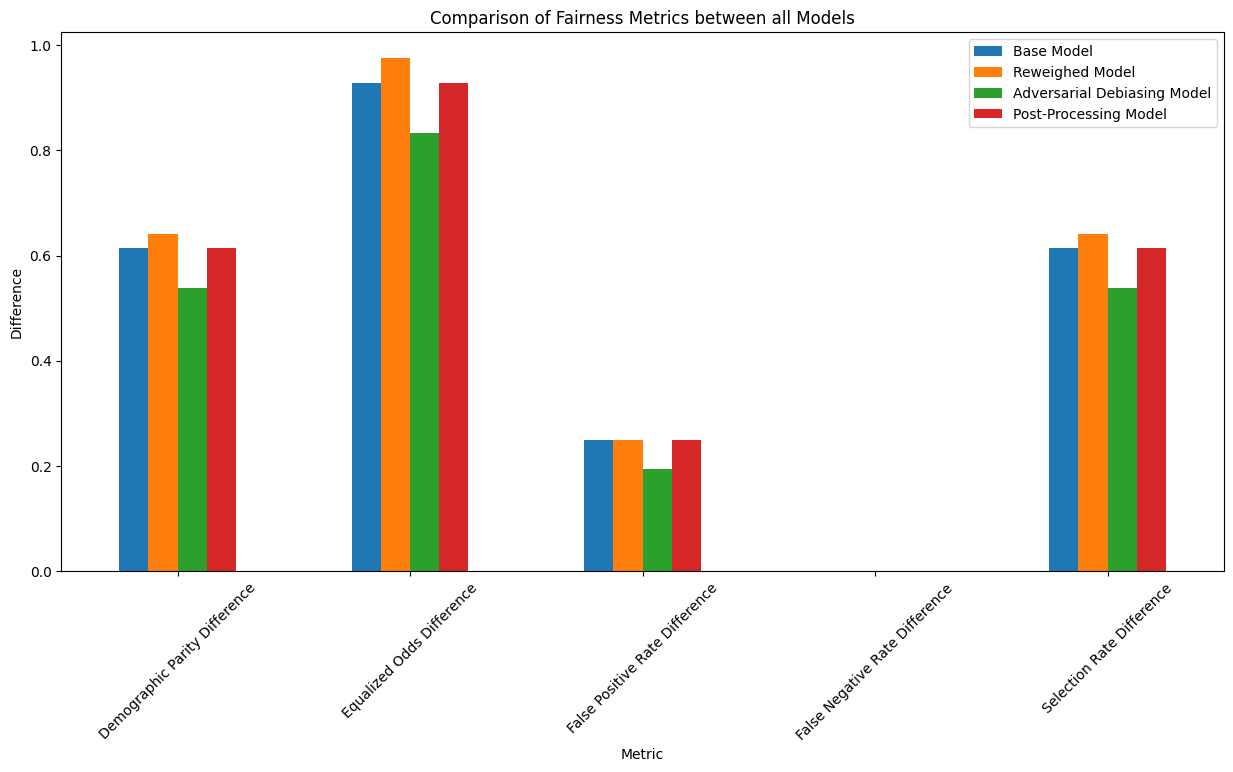

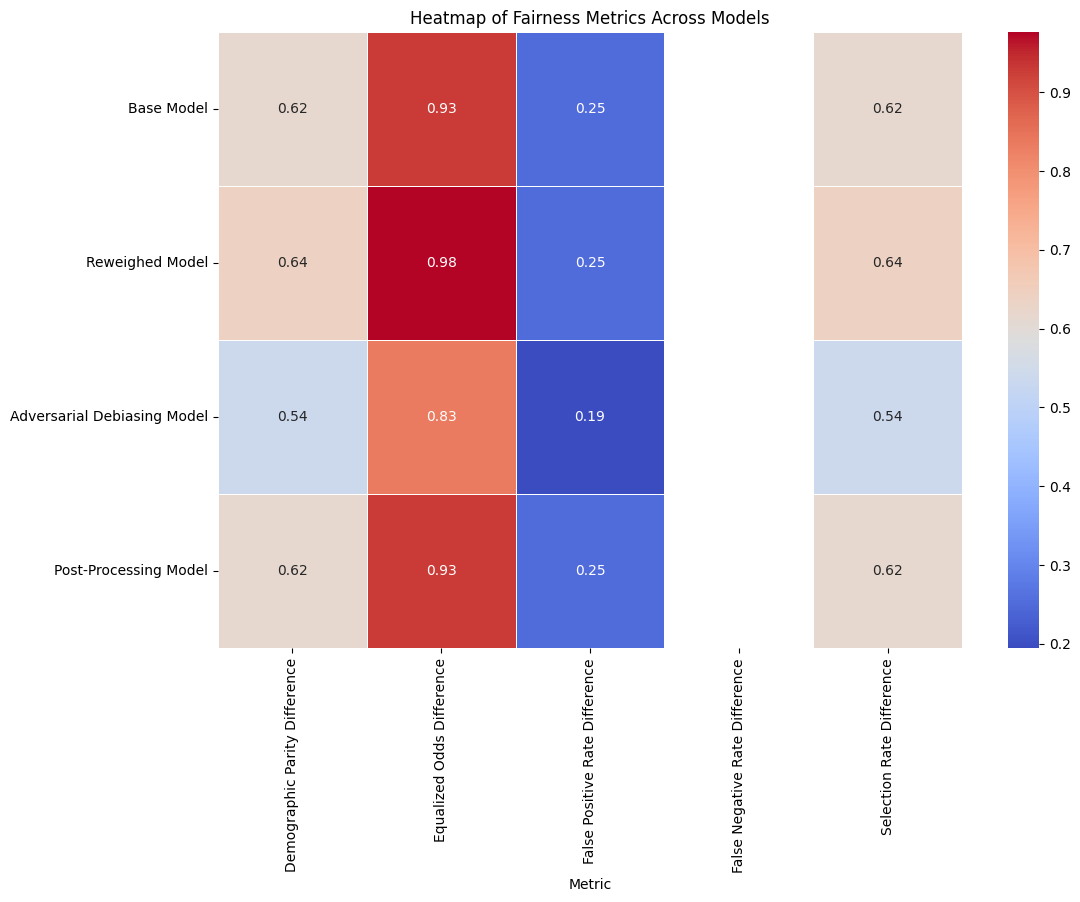

In [8]:
# Plot comparison of fairness metrics
comparison_all.set_index('Metric').plot(kind='bar', figsize=(15, 7))
plt.title('Comparison of Fairness Metrics between all Models')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.show()

# Prepare data for heatmap
heatmap_data = comparison_all.set_index('Metric').transpose()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Fairness Metrics Across Models')
plt.show()


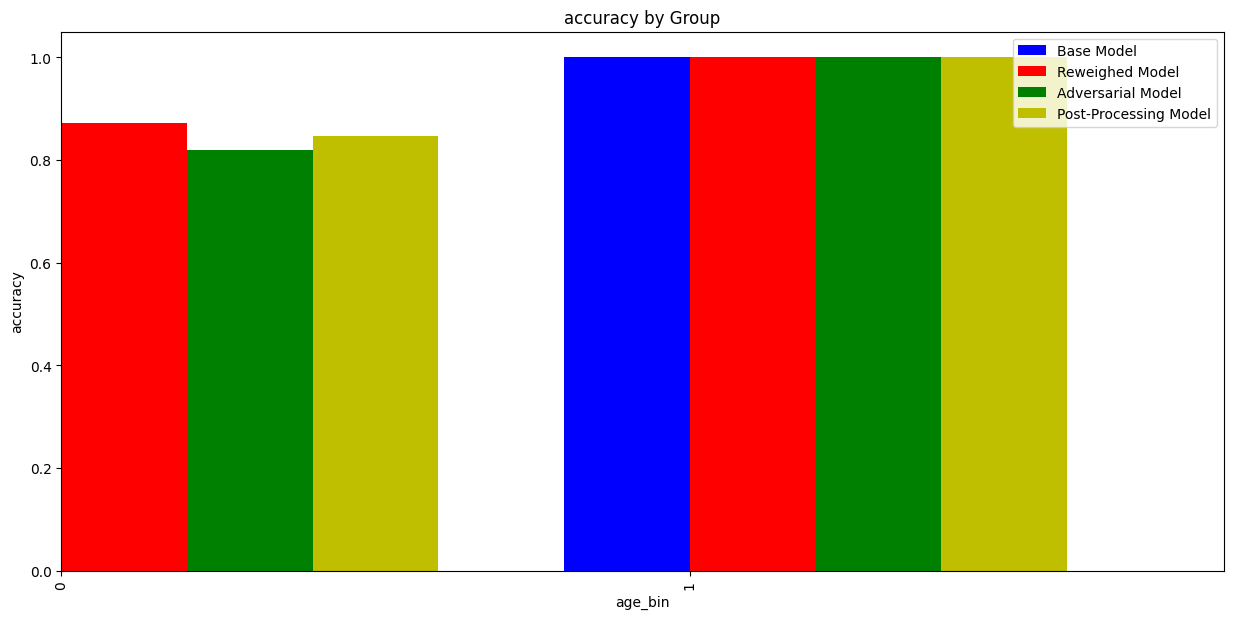

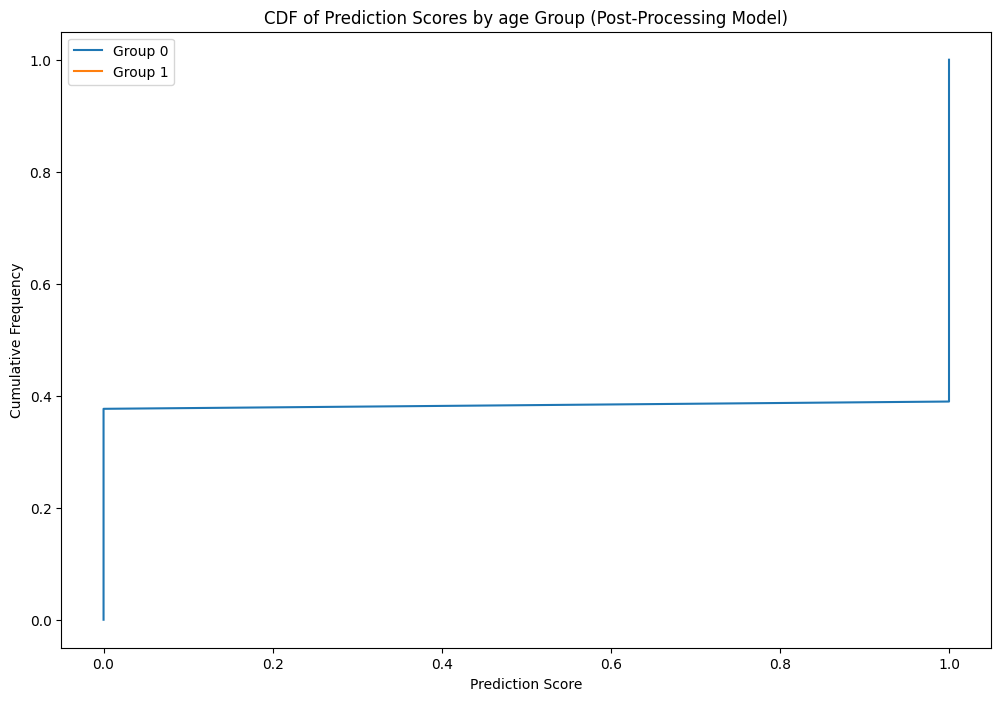

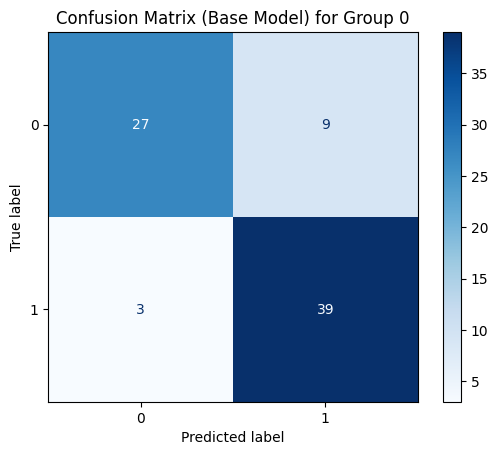

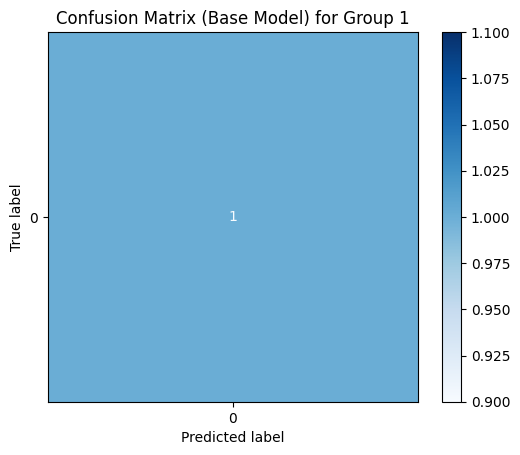

Overall Performance Metrics:
                       accuracy  precision    recall        f1
Base Model             0.848101   0.812500  0.928571  0.866667
Reweighed Model        0.873418   0.820000  0.976190  0.891304
Adversarial Model      0.822785   0.833333  0.833333  0.833333
Post-Processing Model  0.848101   0.812500  0.928571  0.866667


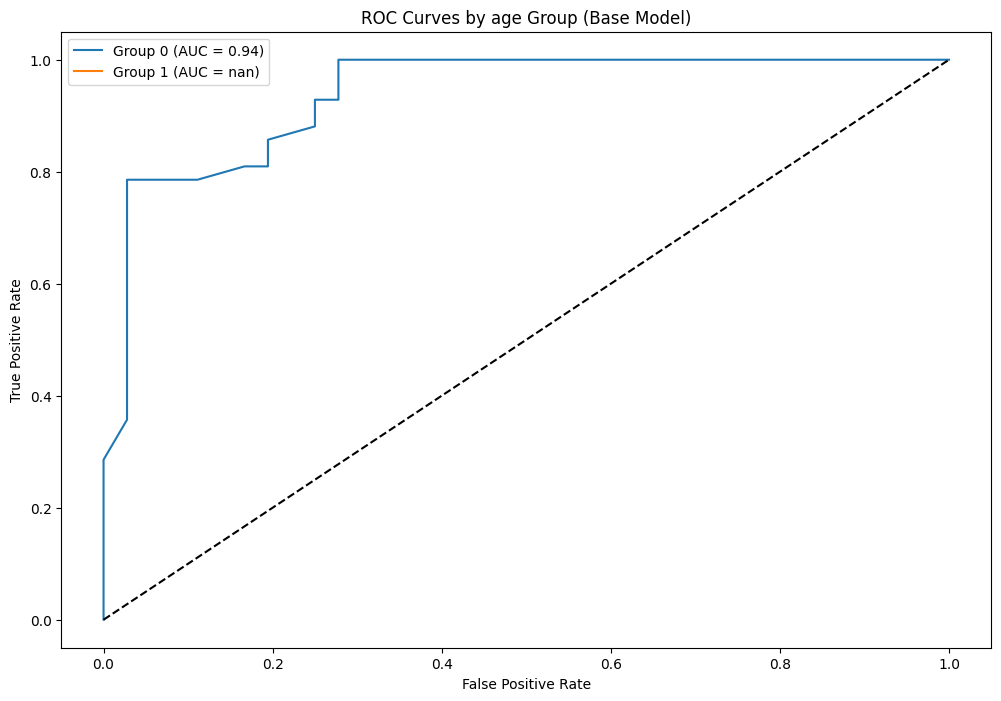

In [9]:
# Additional Visualization Functions

# Extract metrics by group for all models
metrics_by_group_base = metrics_base.by_group.apply(pd.Series)
metrics_by_group_rw = metrics_rw.by_group.apply(pd.Series)
metrics_by_group_adv = metrics_adv.by_group.apply(pd.Series)
metrics_by_group_post_proc = metrics_post_proc.by_group.apply(pd.Series)

def plot_disparity(metric, metric_base, metric_rw, metric_adv, metric_post_proc):
    fig, ax = plt.subplots(figsize=(15, 7))
    width = 0.2
    
    metric_base.plot(kind='bar', width=width, position=1, label='Base Model', ax=ax, color='b')
    metric_rw.plot(kind='bar', width=width, position=0, label='Reweighed Model', ax=ax, color='r')
    metric_adv.plot(kind='bar', width=width, position=-1, label='Adversarial Model', ax=ax, color='g')
    metric_post_proc.plot(kind='bar', width=width, position=-2, label='Post-Processing Model', ax=ax, color='y')
    
    plt.title(f'{metric} by Group')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# Example usage for accuracy
plot_disparity('accuracy', metrics_by_group_base['accuracy'], metrics_by_group_rw['accuracy'], metrics_by_group_adv['accuracy'], metrics_by_group_post_proc['accuracy'])

def plot_cdf(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    plt.figure(figsize=(12, 8))
    
    for name, group in groups:
        y_pred_group = y_pred[group.index]
        sorted_pred = np.sort(y_pred_group)
        yvals = np.arange(len(sorted_pred)) / float(len(sorted_pred) - 1)
        plt.plot(sorted_pred, yvals, label=f'Group {name}')
    
    plt.title(title)
    plt.xlabel('Prediction Score')
    plt.ylabel('Cumulative Frequency')
    plt.legend()
    plt.show()

# Example usage for post-processed model
plot_cdf(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'], 'CDF of Prediction Scores by age Group (Post-Processing Model)')

from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_by_group(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    
    for name, group in groups:
        cm = confusion_matrix(group, y_pred[group.index])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{title} for Group {name}')
        plt.show()

# Example usage for base model
plot_confusion_matrix_by_group(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Base Model)')

def model_performance_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

performance_base = model_performance_metrics(y_test, y_pred_binary)
performance_rw = model_performance_metrics(y_test, y_pred_binary_rw)
performance_adv = model_performance_metrics(y_test, y_pred_adv)
performance_post_proc = model_performance_metrics(y_test, y_pred_post_proc)

performance_df = pd.DataFrame([performance_base, performance_rw, performance_adv, performance_post_proc],
                              index=['Base Model', 'Reweighed Model', 'Adversarial Model', 'Post-Processing Model'])

print("Overall Performance Metrics:")
print(performance_df)

def plot_roc_by_group(y_true, y_pred_proba, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    plt.figure(figsize=(12, 8))
    
    for name, group in groups:
        fpr, tpr, _ = roc_curve(group, y_pred_proba[group.index])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Group {name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Example usage for post-processed model
plot_roc_by_group(y_test, rf_model.predict_proba(X_test)[:, 1], data.loc[X_test.index, 'age_bin'], 'ROC Curves by age Group (Base Model)')


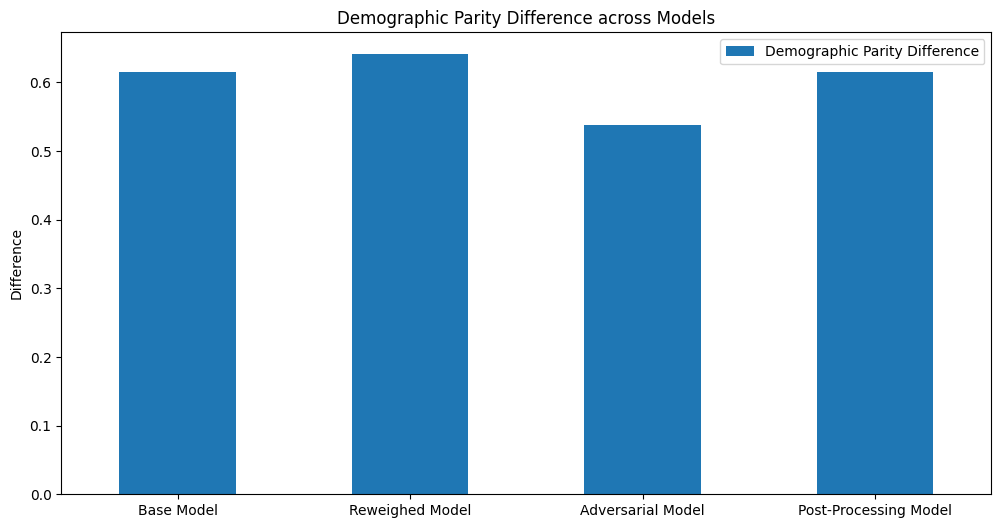

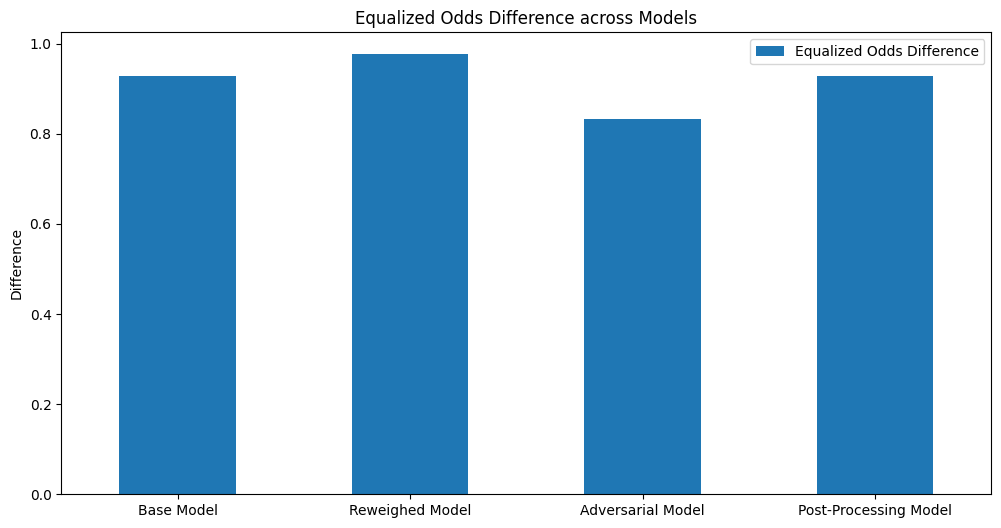

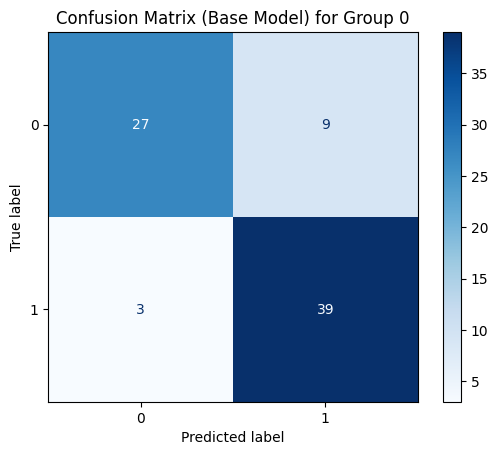

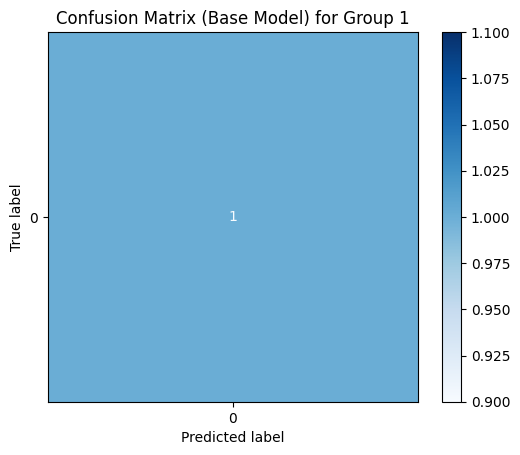

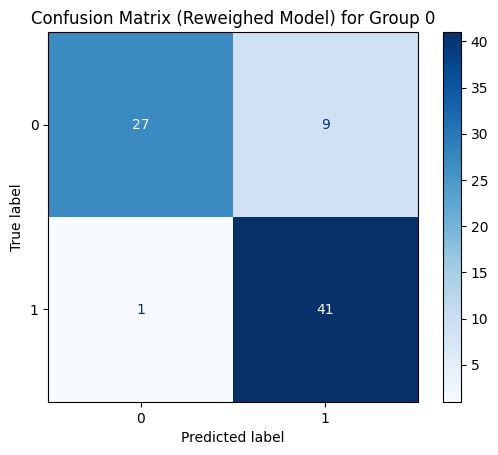

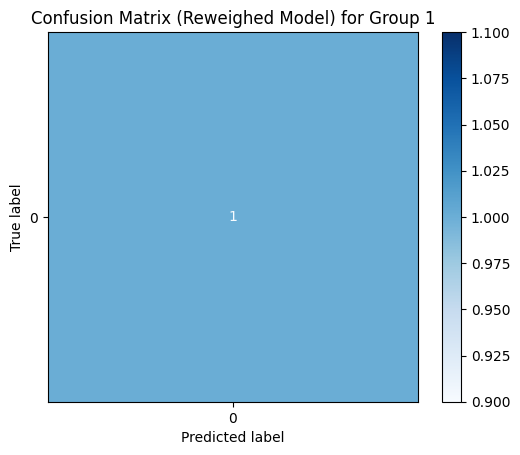

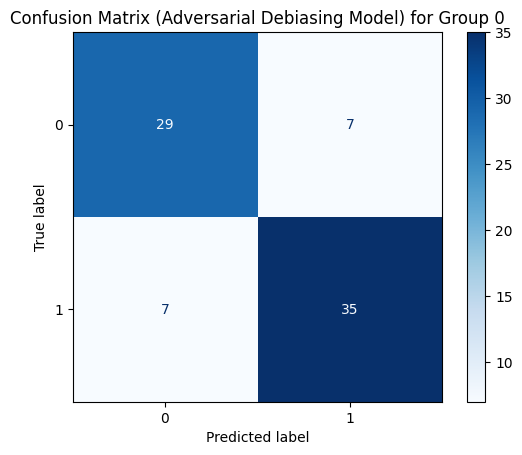

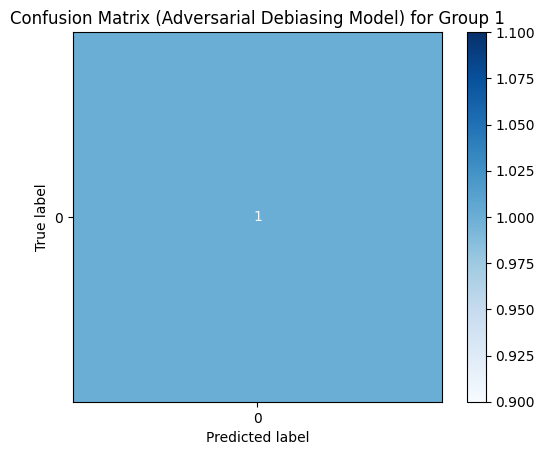

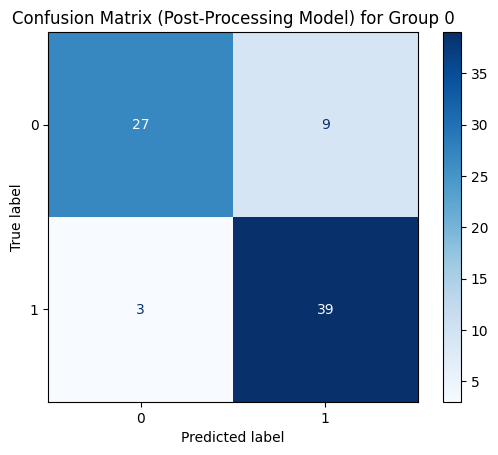

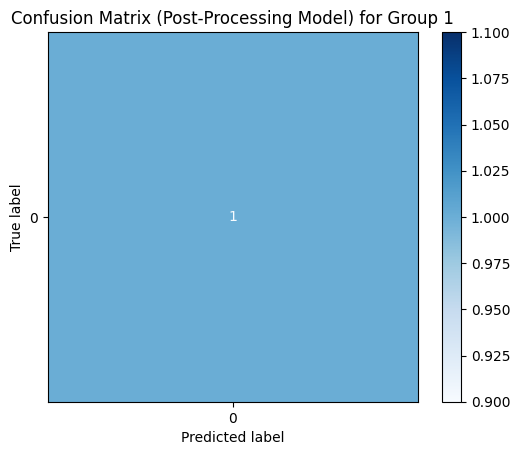

In [10]:
# Visualization of Parity Difference and Equalized Odds

def plot_fairness_metrics(metrics_dict, title):
    df = pd.DataFrame(metrics_dict, index=['Base Model', 'Reweighed Model', 'Adversarial Model', 'Post-Processing Model'])
    df.plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.ylabel('Difference')
    plt.xticks(rotation=0)
    plt.show()

# Plotting Demographic Parity Difference
plot_fairness_metrics(
    {
        'Demographic Parity Difference': [dpd_base, dpd_rw, dpd_adv, dpd_post_proc]
    },
    'Demographic Parity Difference across Models'
)

# Plotting Equalized Odds Difference
plot_fairness_metrics(
    {
        'Equalized Odds Difference': [eod_base, eod_rw, eod_adv, eod_post_proc]
    },
    'Equalized Odds Difference across Models'
)

from sklearn.metrics import ConfusionMatrixDisplay

# Function to plot confusion matrix by group
def plot_confusion_matrix_by_group(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    for name, group in groups:
        cm = confusion_matrix(group, y_pred[group.index])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{title} for Group {name}')
        plt.show()

# Example usage for base model
plot_confusion_matrix_by_group(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Base Model)')

# Example usage for reweighed model
plot_confusion_matrix_by_group(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Reweighed Model)')

# Example usage for adversarial debiasing model
plot_confusion_matrix_by_group(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Adversarial Debiasing Model)')

# Example usage for post-processing model
plot_confusion_matrix_by_group(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Post-Processing Model)')


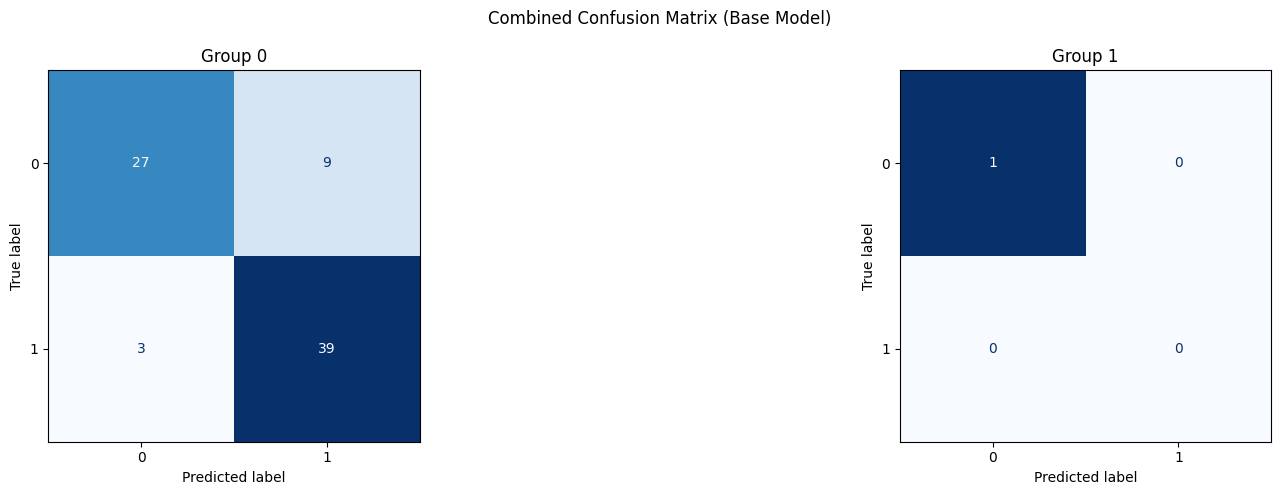

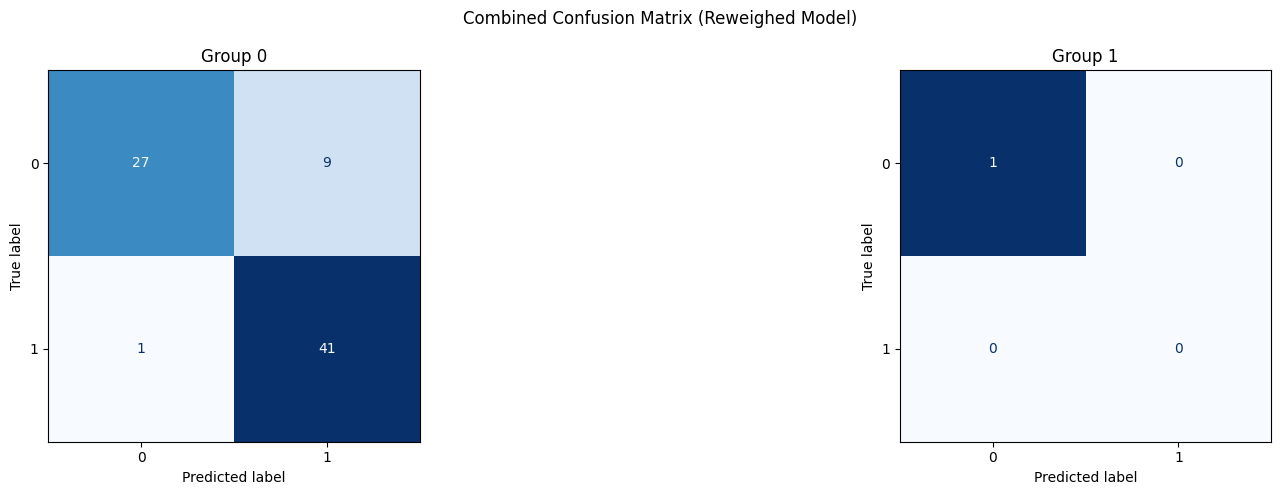

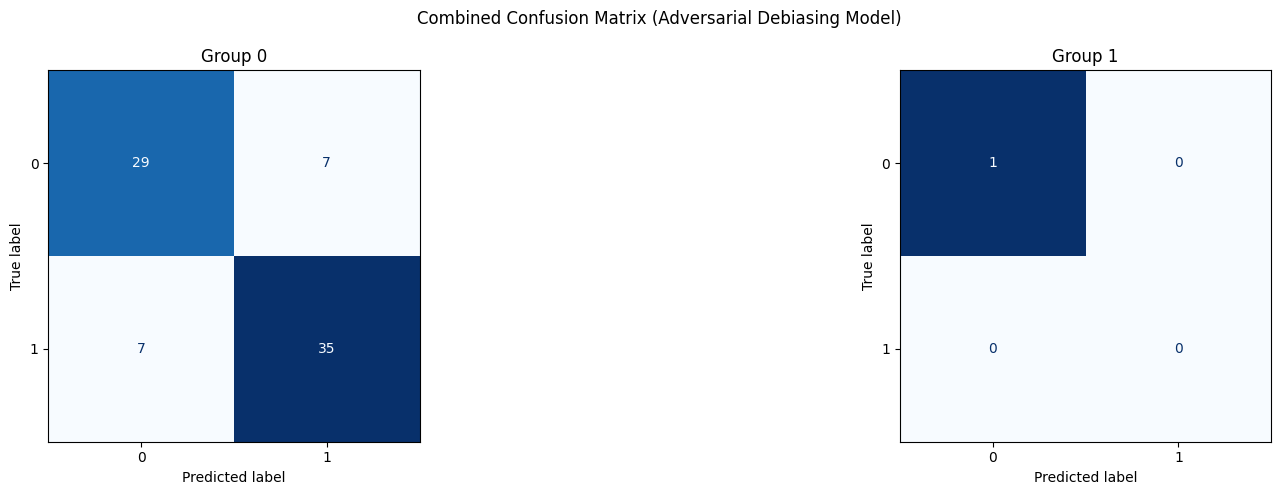

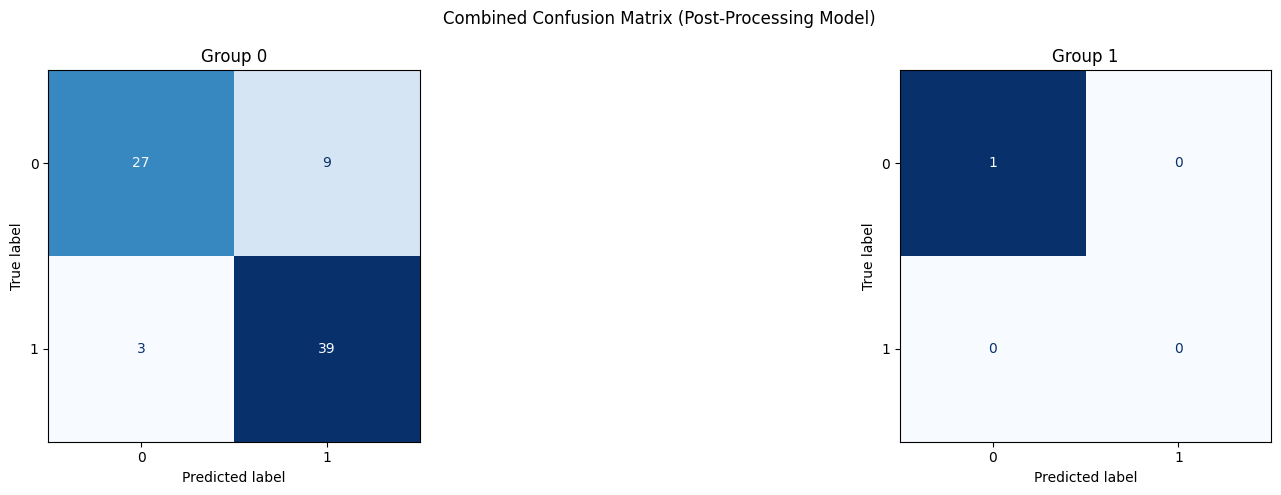

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to plot combined confusion matrix by group
def plot_combined_confusion_matrix(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    n_groups = len(groups)
    fig, axes = plt.subplots(1, n_groups, figsize=(20, 5))
    fig.suptitle(title)
    
    for ax, (name, group) in zip(axes, groups):
        cm = confusion_matrix(group, y_pred[group.index], labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
        ax.title.set_text(f'Group {name}')
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')

    plt.tight_layout()
    plt.show()

# Example usage for base model
plot_combined_confusion_matrix(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'], 'Combined Confusion Matrix (Base Model)')

# Example usage for reweighed model
plot_combined_confusion_matrix(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'], 'Combined Confusion Matrix (Reweighed Model)')

# Example usage for adversarial debiasing model
plot_combined_confusion_matrix(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'], 'Combined Confusion Matrix (Adversarial Debiasing Model)')

# Example usage for post-processing model
plot_combined_confusion_matrix(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'], 'Combined Confusion Matrix (Post-Processing Model)')


In [12]:
import seaborn as sns

# Define custom fairness metric functions if not already defined
def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)


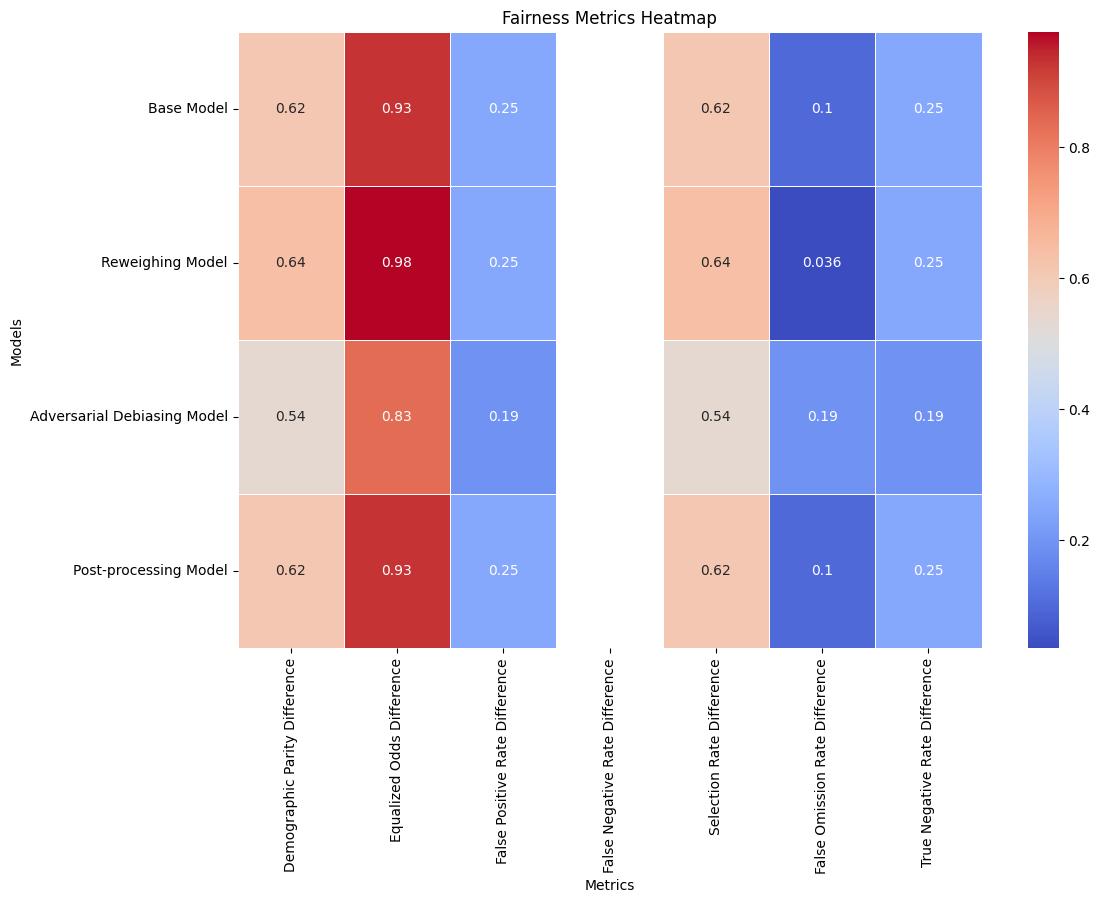

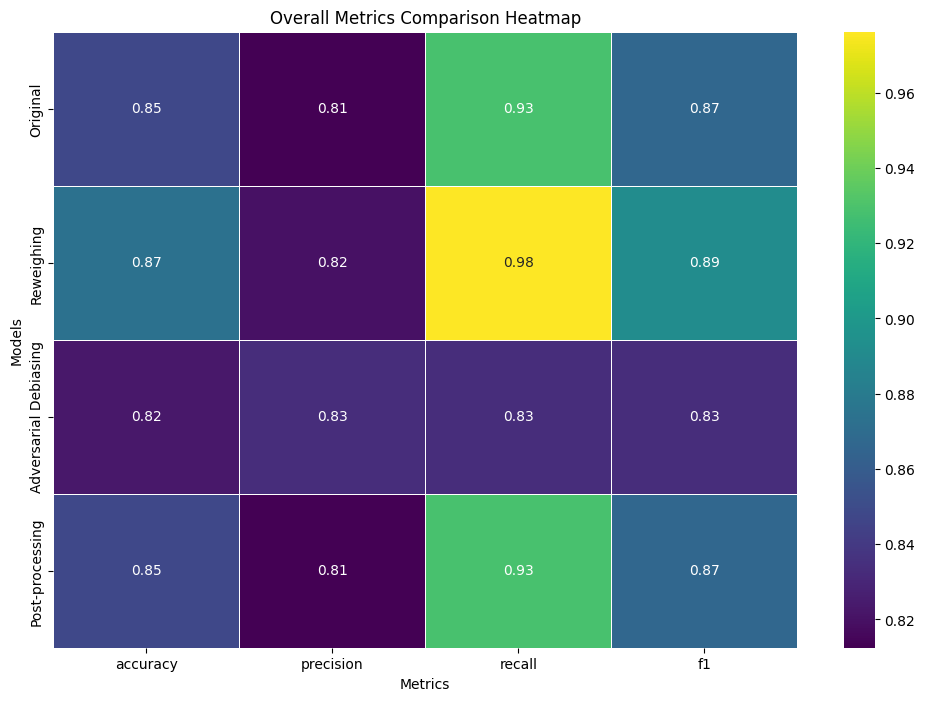

In [13]:
# Create heatmap for fairness metrics
metrics_heatmap_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd_base, dpd_rw, dpd_adv, dpd_post_proc],
    'Equalized Odds Difference': [eod_base, eod_rw, eod_adv, eod_post_proc],
    'False Positive Rate Difference': [fprd_base, fprd_rw, fprd_adv, fprd_post_proc],
    'False Negative Rate Difference': [fnrd_base, fnrd_rw, fnrd_adv, fnrd_post_proc],
    'Selection Rate Difference': [srd_base, srd_rw, srd_adv, srd_post_proc],
    'False Omission Rate Difference': [false_omission_rate_difference(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin']),
                                       false_omission_rate_difference(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin']),
                                       false_omission_rate_difference(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin']),
                                       false_omission_rate_difference(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])],
    'True Negative Rate Difference': [true_negative_rate_difference(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin']),
                                      true_negative_rate_difference(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin']),
                                      true_negative_rate_difference(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin']),
                                      true_negative_rate_difference(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])]
}, index=['Base Model', 'Reweighing Model', 'Adversarial Debiasing Model', 'Post-processing Model'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()

# Comparison heatmap for overall metrics
comparison_heatmap_data = pd.DataFrame({
    'Original': performance_base,
    'Reweighing': performance_rw,
    'Adversarial Debiasing': performance_adv,
    'Post-processing': performance_post_proc
}).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()


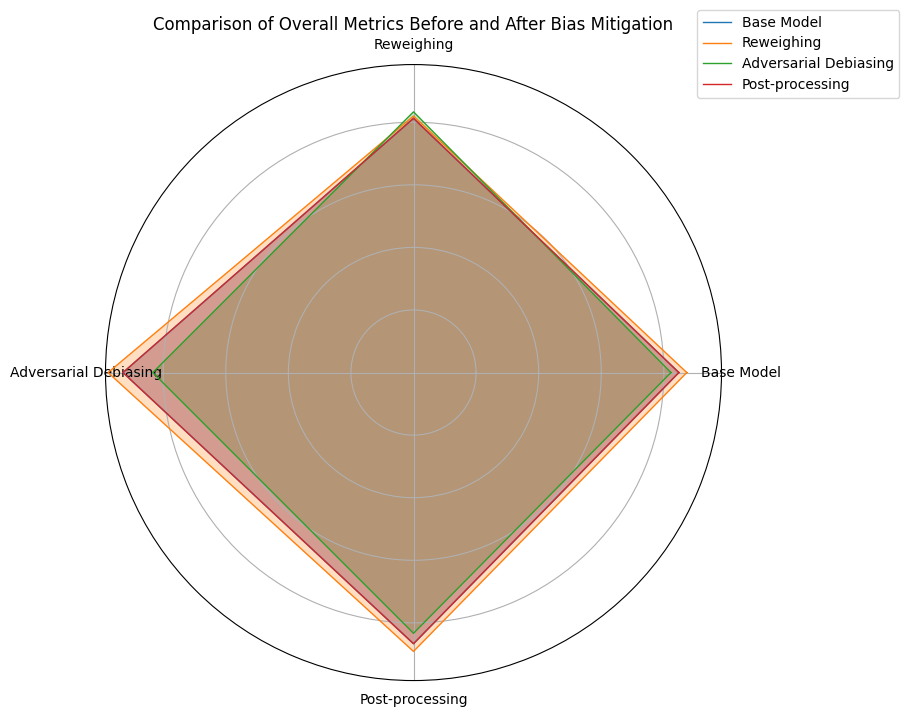

Additional visualizations done.


In [14]:
# Radar plot for visual comparison
from math import pi

def plot_radar_chart(metrics_dict, title):
    labels = list(metrics_dict.keys())
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for model, metrics in metrics_dict.items():
        values = list(metrics.values())
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(title)
    plt.show()

metrics_for_radar = {
    'Base Model': performance_base,
    'Reweighing': performance_rw,
    'Adversarial Debiasing': performance_adv,
    'Post-processing': performance_post_proc
}

plot_radar_chart(metrics_for_radar, 'Comparison of Overall Metrics Before and After Bias Mitigation')

print("Additional visualizations done.")


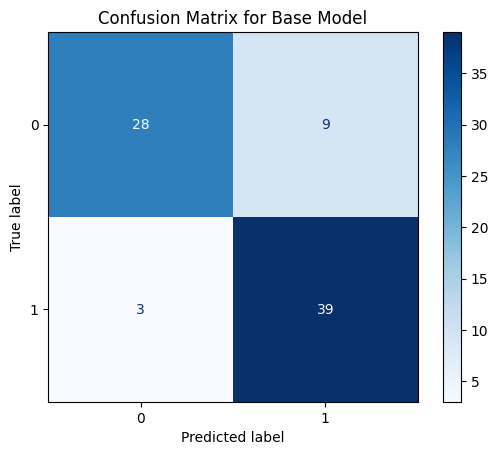

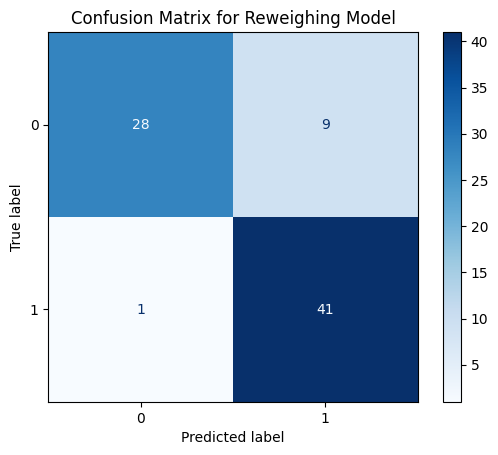

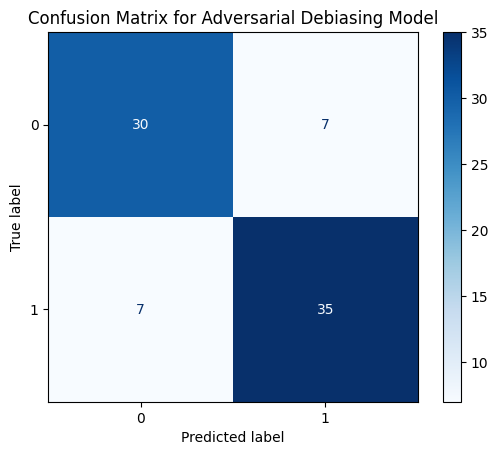

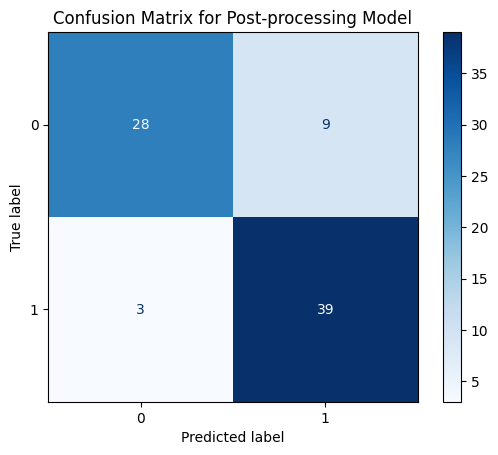

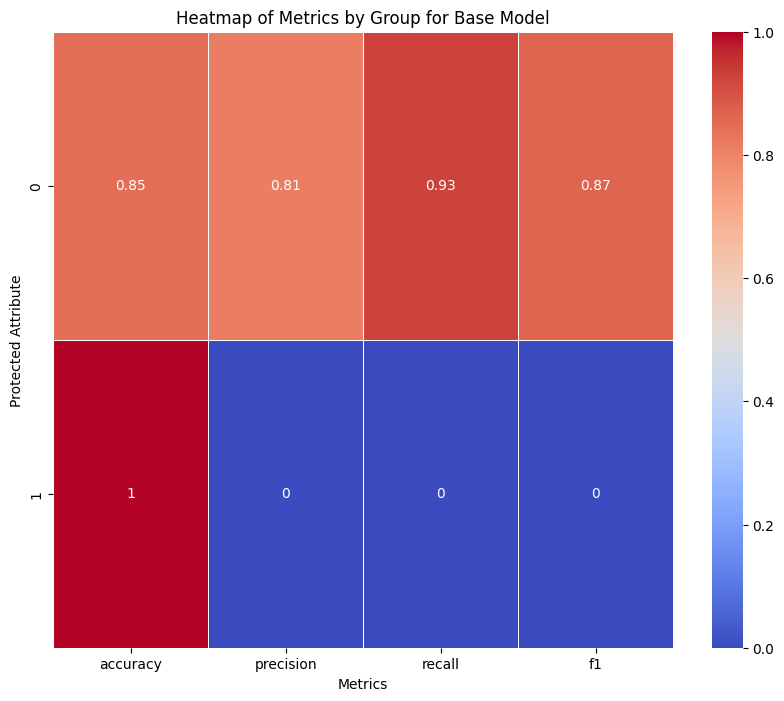

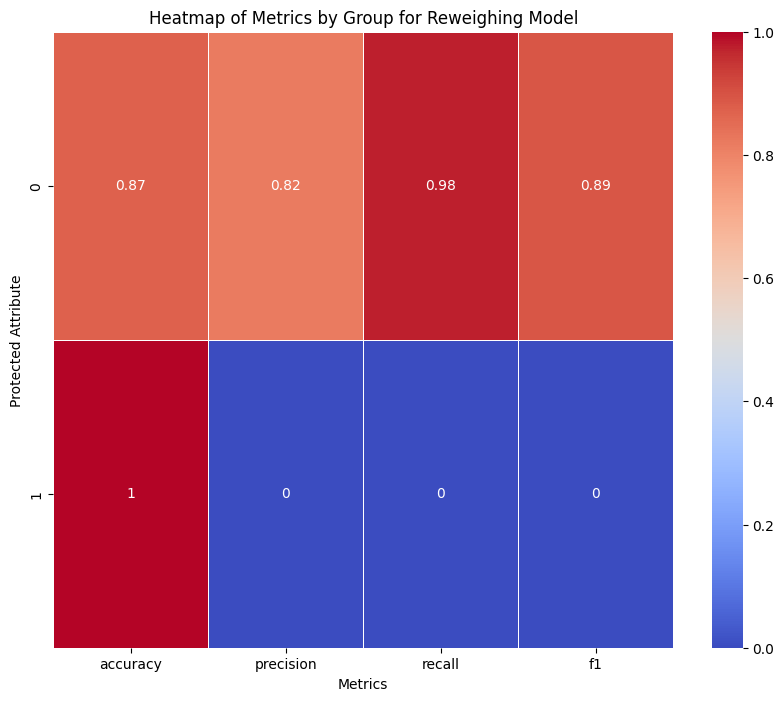

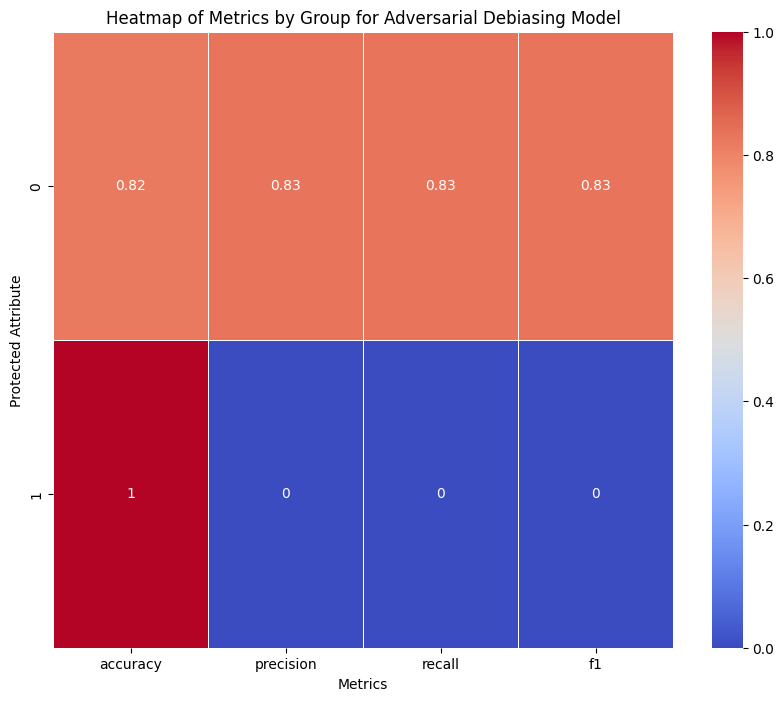

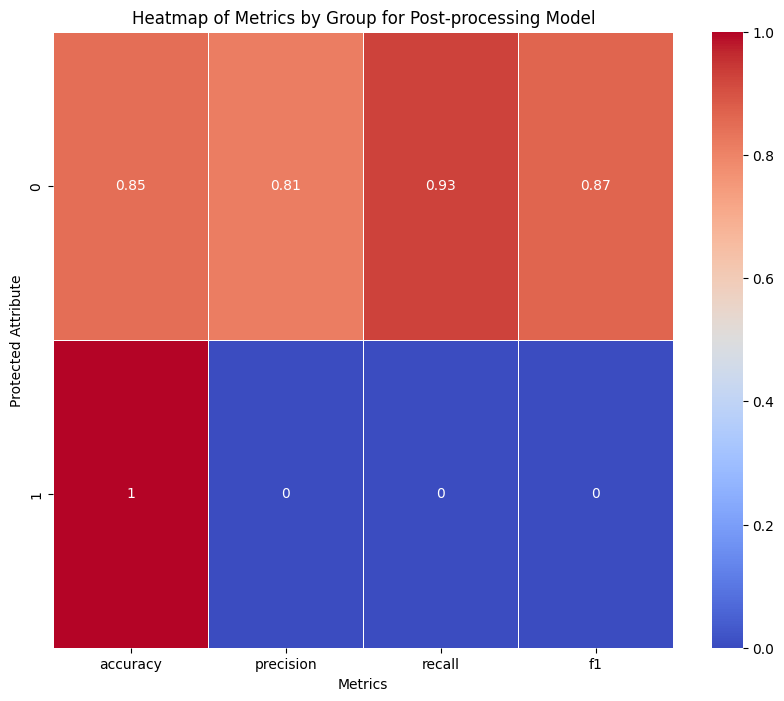

Additional confusion matrices and heatmaps done.


In [15]:
# Display confusion matrix for each model

def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Confusion matrices for each model
plot_confusion_matrix("Base Model", y_test, y_pred_binary)
plot_confusion_matrix("Reweighing Model", y_test, y_pred_binary_rw)
plot_confusion_matrix("Adversarial Debiasing Model", y_test, y_pred_adv)
plot_confusion_matrix("Post-processing Model", y_test, y_pred_post_proc)

# Heatmap for each model individually
def plot_model_heatmap(model_name, metrics_by_group):
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_by_group, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title(f'Heatmap of Metrics by Group for {model_name}')
    plt.ylabel('Protected Attribute')
    plt.xlabel('Metrics')
    plt.show()

# Heatmaps for each model
plot_model_heatmap("Base Model", metrics_by_group_base)
plot_model_heatmap("Reweighing Model", metrics_by_group_rw)
plot_model_heatmap("Adversarial Debiasing Model", metrics_by_group_adv)
plot_model_heatmap("Post-processing Model", metrics_by_group_post_proc)

print("Additional confusion matrices and heatmaps done.")


In [16]:
# Function to calculate fairness metrics
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fprd = false_positive_rate_difference(y_true, y_pred, sensitive_features)
    fnrd = false_negative_rate_difference(y_true, y_pred, sensitive_features)
    srd = selection_rate_difference(y_pred, sensitive_features)
    for_diff = false_omission_rate_difference(y_true, y_pred, sensitive_features)
    tnr_diff = true_negative_rate_difference(y_true, y_pred, sensitive_features)
    
    return {
        'Demographic Parity Difference': dpd,
        'Equalized Odds Difference': eod,
        'False Positive Rate Difference': fprd,
        'False Negative Rate Difference': fnrd,
        'Selection Rate Difference': srd,
        'False Omission Rate Difference': for_diff,
        'True Negative Rate Difference': tnr_diff
    }

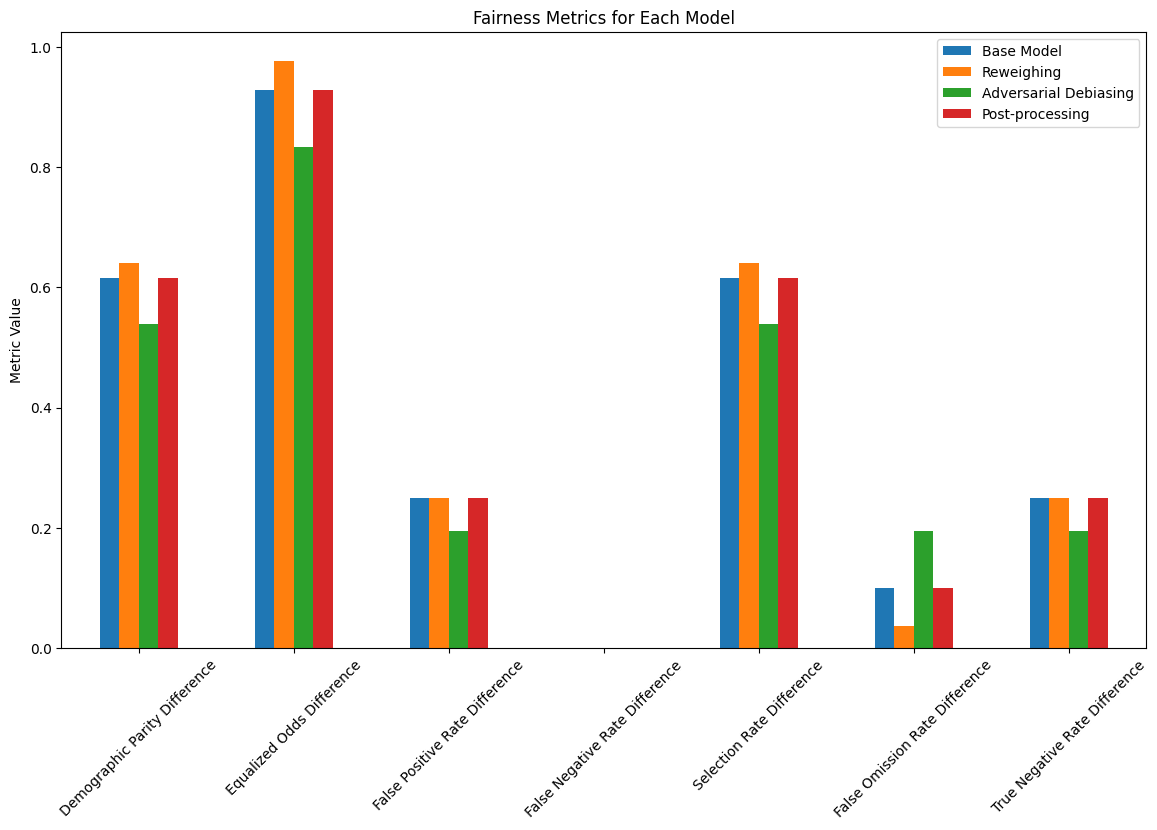

In [17]:
# Fairness metrics for each model
fairness_metrics_base = calculate_fairness_metrics(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'])
fairness_metrics_rw = calculate_fairness_metrics(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'])
fairness_metrics_adv = calculate_fairness_metrics(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'])
fairness_metrics_pp = calculate_fairness_metrics(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])

# Create DataFrame for plotting
fairness_metrics_df = pd.DataFrame({
    'Base Model': fairness_metrics_base,
    'Reweighing': fairness_metrics_rw,
    'Adversarial Debiasing': fairness_metrics_adv,
    'Post-processing': fairness_metrics_pp
})

# Plot fairness metrics for each model
fairness_metrics_df.plot(kind='bar', figsize=(14, 8), title='Fairness Metrics for Each Model')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()